# Geo2025 – Floodproof Rotterdam Hackathon

In this notebook you will:

-  Load and wrangle the provided geospatial datasets  
- Enrich points with:
   - Reverse–geocoded metadata from OpenStreetMap (class / type)
   - RD (Rijksdriehoeks) coordinates from a precomputed lookup
-  Build training data from a geological voxel model (subsurface grid)
-  Train one or more classification models to predict lithology (soil class)
-  Generate predictions for the **18 hackathon test locations** and save a CSV for the leaderboard

You should only use tools and ideas covered in:

- S02 SLU01–06, BLU01–02 (Pandas, wrangling)
- BLU03 (APIs – `requests`, JSON)
- SLU07–10, SLU11, SLU13–15 (Regression, Classification, Metrics, Trees, Random Forests)
- SLU15–16 (Pipelines, `StandardScaler`, basic tuning)

---

## Story (short recap)

Rotterdam is building **underground flood-storage basins** (water buffers) to reduce flood risk.  
Whether a location is suitable depends strongly on the **subsurface lithology** (soil type):

- `zand_grof` (coarse sand) – excellent drainage  
- `zand_matig_grof` (medium sand) – good  
- `zand_fijn` (fine sand) – acceptable  
- `klei` (clay) – very poor drainage  
- `kleiig_zand` (sandy clay) – mixed behavior  
- `veen` (peat) – unstable for heavy structures  

You will:

- Use a voxel model of South Holland’s subsurface  
- Train models to predict lithology at depth  
- Submit your predictions for 18 test locations to the leaderboard.


In [4]:
# ! pip install pyarrow
# ! pip install fastparquet

In [21]:
from pathlib import Path
import random

import numpy as np
import pandas as pd
import pyarrow as pa
import requests

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

sns.set_style("whitegrid")

# Path to the data folder (relative to this notebook)
# DATA_DIR = Path(r"\data")
DATA_DIR = Path("data")

GEO_VOXELS = DATA_DIR / "geotop_south_holland_student.parquet"
MAPPING_JSON = DATA_DIR / "mapping_geo_coordinates_to_RD_coordinates.json"
TEST_CSV = DATA_DIR / "test_dataset.csv"
SAMPLE_SUB_CSV = DATA_DIR / "sample_submission.csv"  
MY_SUBMISSION_CSV = DATA_DIR / "my_submission.csv"

# cache for OSM labels for training voxels
TRAIN_OSM_CACHE = DATA_DIR / "train_voxels_osm_labels.csv"

# Depth configuration
DEPTH_CHOICE = -20.0   # meters
DEPTH_TOLERANCE = 0.5  # meters

# RNG seed
RNG_SEED = 2025
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)

# Nominatim API
NOMINATIM_URL = "https://nominatim.openstreetmap.org/reverse"

# IMPORTANT: replace this with YOUR email (required by Nominatim usage policy)
CONTACT_EMAIL = "puzinanata@gmail.com" #"your_email_here@example.com"


##  Load the datasets

## Step 1 – Load voxel model, mapping file, and test dataset

We now load:

- `geotop_south_holland_student.parquet`  
  - 3D voxel model of the subsurface (student-safe, some voxels removed).
- `mapping_geo_coordinates_to_RD_coordinates.json`  
  - Mapping between RD coordinates (`RD_east`, `RD_north`) and latitude/longitude.
  - This is useful if you want to relate voxels to real-world locations.
- `test_dataset.csv`  
  - The 18 locations for which we must predict the lithology.
  - Already contains RD coordinates (`RD_east`, `RD_north`).



In [22]:
voxels = pd.read_parquet(GEO_VOXELS, engine="fastparquet")
print("Voxels shape:", voxels.shape)
voxels.head()


Voxels shape: (391942, 14)


,x,y,z,lithoklasse_id,lithoklasse,kans_1_veen,kans_2_klei,kans_3_kleiig_zand,kans_4_vervallen,kans_5_zand_fijn,kans_6_zand_matig_grof,kans_7_zand_grof,kans_8_grind,kans_9_schelpen
0,89550.0,432850.0,-7.75,0,NaN,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0
1,89550.0,432850.0,-8.25,3,kleiig_zand,0.06,0.07,0.27,0.0,0.33,0.16,0.11,0.0,0.0
2,89550.0,432850.0,-8.75,2,klei,0.14,0.52,0.34,0.0,0.00,0.00,0.00,0.0,0.0
3,89550.0,432850.0,-9.25,2,klei,0.12,0.57,0.31,0.0,0.00,0.00,0.00,0.0,0.0
4,89550.0,432850.0,-9.75,2,klei,0.13,0.58,0.29,0.0,0.00,0.00,0.00,0.0,0.0


In [23]:
mapping = pd.read_json(MAPPING_JSON, orient="records", lines=True)
print("Mapping shape:", mapping.shape)
mapping.head()


Mapping shape: (4026, 4)


,latitude,longitude,RD_east,RD_north
0,51.880335,4.436639,89550,432850
1,51.881234,4.436620,89550,432950
2,51.882133,4.436601,89550,433050
3,51.883032,4.436582,89550,433150
4,51.883930,4.436563,89550,433250


In [24]:
test_df = pd.read_csv(TEST_CSV)
print("Test dataset shape:", test_df.shape)
test_df.head()


Test dataset shape: (18, 9)


,ID,cityName,displayName,latitude,longitude,class,type,RD_east,RD_north
0,0,5283,"152, Groen van Prinstererstraat, Hoogstad, Vla...",51.912476,4.341611,place,house,83037.716304,436409.155066
1,1,5307,"533, Andries van Bronckhorstlaan, Centrum, Spi...",51.844980,4.329021,place,house,82062.232477,428913.878985
2,2,5314,"van Lennepstraat, 's- Gravenzande, 's-Gravenza...",52.001555,4.165362,amenity,parking,71079.916971,446506.937484
3,3,5317,"Van Smaleveltstraat, Schiedam, Zuid-Holland, N...",51.918160,4.387831,man_made,tunnel,86226.007827,436996.718946
4,4,5318,"304, Ganzerikplein, Schiebroek, Hillegersberg-...",51.958796,4.471991,place,house,92071.841460,441440.635968


## Step 2 – Select depth slice and target column

The voxel model contains:

- `x`, `y` – RD coordinates (meters)  
- `z` – depth (meters, negative below surface)  
- `lithoklasse` or `lithoclass` – the lithology (soil class)

We:

1. Detect which lithology column is present.  
2. Select voxels at depth `DEPTH_CHOICE ± DEPTH_TOLERANCE`.  
3. Keep only rows where lithology is not missing.


In [25]:
# Detect lithology column
if "lithoklasse" in voxels.columns:
    litho_col = "lithoklasse"
elif "lithoclass" in voxels.columns:
    litho_col = "lithoclass"
else:
    raise ValueError("No lithology column ('lithoklasse' or 'lithoclass') found in voxels.")

print("Using lithology column:", litho_col)


Using lithology column: lithoklasse


In [26]:
# Filter by depth: DEPTH_CHOICE ± DEPTH_TOLERANCE
depth_mask = (voxels["z"].sub(DEPTH_CHOICE).abs() <= DEPTH_TOLERANCE)

train_slice = voxels.loc[
    depth_mask,
    ["x", "y", "z", litho_col]
].dropna(subset=[litho_col]).copy()

print("Training slice at depth window (unfiltered):", train_slice.shape)
train_slice.head()


Training slice at depth window (unfiltered): (8038, 4)


,x,y,z,lithoklasse
25,89550.0,432850.0,-20.25,zand_matig_grof
106,89550.0,432950.0,-19.75,zand_matig_grof
107,89550.0,432950.0,-20.25,zand_matig_grof
213,89550.0,433050.0,-19.75,zand_matig_grof
214,89550.0,433050.0,-20.25,zand_matig_grof


## Step 3 – Attach latitude/longitude to training voxels

The mapping file `mapping_geo_coordinates_to_RD_coordinates.json` was precomputed
from the voxel grid using an official transformation (pyproj).

It contains:

- `RD_east`, `RD_north`
- `latitude`, `longitude`

We join this mapping onto our depth slice using:

- `x` ↔ `RD_east`  
- `y` ↔ `RD_north`

This gives us the surface coordinates above each training voxel.

In [27]:
train_with_coords = train_slice.merge(
    mapping,
    left_on=["x", "y"],
    right_on=["RD_east", "RD_north"],
    how="left",
)

print("Train slice with lat/lon info:", train_with_coords.shape)
train_with_coords.head()


Train slice with lat/lon info: (8038, 8)


,x,y,z,lithoklasse,latitude,longitude,RD_east,RD_north
0,89550.0,432850.0,-20.25,zand_matig_grof,51.880335,4.436639,89550,432850
1,89550.0,432950.0,-19.75,zand_matig_grof,51.881234,4.436620,89550,432950
2,89550.0,432950.0,-20.25,zand_matig_grof,51.881234,4.436620,89550,432950
3,89550.0,433050.0,-19.75,zand_matig_grof,51.882133,4.436601,89550,433050
4,89550.0,433050.0,-20.25,zand_matig_grof,51.882133,4.436601,89550,433050


## Step 4 – Use the Nominatim API to get OSM `class` and `type` for training voxels

We will now use the **Nominatim** reverse geocoding API to get metadata for
the surface above our training voxels.

For each unique `(RD_east, RD_north, latitude, longitude)` we:

1. Call `https://nominatim.openstreetmap.org/reverse`  
2. Get a JSON response  
3. Extract:
   - `class` → `osm_class`
   - `type` → `osm_type`

Since this can be slow and is rate-limited:

- We only call the API if a cache file (`train_voxels_osm_labels.csv`) does **not** exist.  
- Otherwise, we reuse the cached label file.


In [28]:
def reverse_geocode_coords(df: pd.DataFrame) -> pd.DataFrame:
    """
    Call Nominatim for each row with columns: latitude, longitude.
    Returns a dataframe with RD_east, RD_north, osm_class, osm_type.
    """
    rows = []
    for i, row in df.iterrows():
        lat = row["latitude"]
        lon = row["longitude"]

        params = {
            "lat": lat,
            "lon": lon,
            "format": "json",
            "addressdetails": 1,
        }
        headers = {"User-Agent": f"ldsa-geo2025/1.0 ({CONTACT_EMAIL})"}

        resp = requests.get(NOMINATIM_URL, params=params, headers=headers)
        resp.raise_for_status()
        data = resp.json()

        osm_class = data.get("class", None)
        osm_type = data.get("type", None)

        rows.append({
            "RD_east": row["RD_east"],
            "RD_north": row["RD_north"],
            "latitude": lat,
            "longitude": lon,
            "osm_class": osm_class,
            "osm_type": osm_type,
        })

    return pd.DataFrame(rows)


In [29]:
if TRAIN_OSM_CACHE.exists():
    print("Loading cached OSM labels from:", TRAIN_OSM_CACHE)
    train_osm = pd.read_csv(TRAIN_OSM_CACHE)
else:
    # Drop rows without lat/lon
    coords_for_osm = train_with_coords.dropna(subset=["latitude", "longitude"]).copy()

    # deduplicate RD points so we don't call the API multiple times
    coords_for_osm = coords_for_osm[["RD_east", "RD_north", "latitude", "longitude"]].drop_duplicates()

    print("Calling Nominatim for", coords_for_osm.shape[0], "points...")
    train_osm = reverse_geocode_coords(coords_for_osm)
    train_osm.to_csv(TRAIN_OSM_CACHE, index=False)
    print("Saved OSM labels to:", TRAIN_OSM_CACHE)

print("train_osm shape:", train_osm.shape)
train_osm.head()


Calling Nominatim for 4026 points...
Saved OSM labels to: data/train_voxels_osm_labels.csv
train_osm shape: (4026, 6)


,RD_east,RD_north,latitude,longitude,osm_class,osm_type
0,89550.0,432850.0,51.880335,4.436639,highway,service
1,89550.0,432950.0,51.881234,4.436620,highway,service
2,89550.0,433050.0,51.882133,4.436601,highway,service
3,89550.0,433150.0,51.883032,4.436582,highway,service
4,89550.0,433250.0,51.883930,4.436563,highway,service


In [30]:
print("Unique OSM types:", train_osm["osm_type"].unique())
print("Unique OSM classes:", train_osm["osm_class"].unique())


Unique OSM types: ['service' 'house' 'pedestrian' 'life_ring' 'cycleway' 'car_wash' 'fuel'
 'mall' 'school' 'residential' 'childcare' 'parking' 'tertiary' 'prison'
 'wholesale' 'motorway' 'works' 'bench' 'secondary' 'tower' 'bridge'
 'pitch' 'information' 'marina' 'houseboat' 'primary' 'fountain' 'garden'
 'footway' 'playground' 'taxi' 'place_of_worship' 'optician' 'clothes'
 'nightclub' 'sports_centre' 'social_facility' 'pier' 'atm' 'supermarket'
 'bar' 'artwork' 'fitness_centre' 'sports' 'construction' 'pub'
 'vending_machine' 'fast_food' 'townhall' 'dentist' 'dog_park' 'archive'
 'picnic_table' 'museum' 'restaurant' 'company' 'events_venue' 'massage'
 'apartments' 'attraction' 'waste_basket' 'charging_station'
 'unclassified' 'marketplace' 'bakery' 'cafe' 'stadium'
 'conference_centre' 'shelter' 'swimming_area' 'drinking_water' 'tattoo'
 'hotel' 'tram_stop' 'educational_institution' 'religion' 'university'
 'gift' 'siren' 'photo' 'outdoor_seating' 'food_court' 'bicycle_parking'
 'ye

## Step 5 – Filter training voxels using OSM `type`

We now join the OSM labels back onto the depth slice and **filter out** voxels under
unstable or undefined surface types.

We remove rows where:

- `osm_type == "construction"` (ground likely disturbed), or  
- `osm_type` is missing (`NaN`)

This ensures our training set focuses on more stable subsurface conditions.


In [31]:
train_with_osm = train_with_coords.merge(
    train_osm[["RD_east", "RD_north", "osm_class", "osm_type"]],
    on=["RD_east", "RD_north"],
    how="left",
)

print("Train slice with OSM info:", train_with_osm.shape)
train_with_osm[[ "x", "y", "z", litho_col, "osm_class", "osm_type" ]].head()


Train slice with OSM info: (8038, 10)


,x,y,z,lithoklasse,osm_class,osm_type
0,89550.0,432850.0,-20.25,zand_matig_grof,highway,service
1,89550.0,432950.0,-19.75,zand_matig_grof,highway,service
2,89550.0,432950.0,-20.25,zand_matig_grof,highway,service
3,89550.0,433050.0,-19.75,zand_matig_grof,highway,service
4,89550.0,433050.0,-20.25,zand_matig_grof,highway,service


In [32]:
# Define disallowed types
DISALLOWED_TYPES = {"construction"}

mask_type_defined = train_with_osm["osm_type"].notna()
mask_not_disallowed = ~train_with_osm["osm_type"].isin(DISALLOWED_TYPES)

mask_keep = mask_type_defined & mask_not_disallowed

train_filtered = train_with_osm.loc[
    mask_keep,
    ["x", "y", "z", litho_col]
].dropna(subset=[litho_col]).copy()

print("Training voxels after OSM filtering:", train_filtered.shape)
train_filtered.head()


Training voxels after OSM filtering: (8032, 4)


,x,y,z,lithoklasse
0,89550.0,432850.0,-20.25,zand_matig_grof
1,89550.0,432950.0,-19.75,zand_matig_grof
2,89550.0,432950.0,-20.25,zand_matig_grof
3,89550.0,433050.0,-19.75,zand_matig_grof
4,89550.0,433050.0,-20.25,zand_matig_grof


## Step 6 – Quick EDA of lithology distribution 
Before training, it’s useful to see how the classes are distributed.
This can help interpret Macro-F1 results later.


In [33]:
litho_counts = train_filtered[litho_col].value_counts(normalize=True)
print("Lithology class proportions after filtering:")
litho_counts


Lithology class proportions after filtering:


lithoklasse
zand_matig_grof    0.563745
zand_grof          0.323954
zand_fijn          0.076693
kleiig_zand        0.023531
klei               0.012077
Name: proportion, dtype: float64

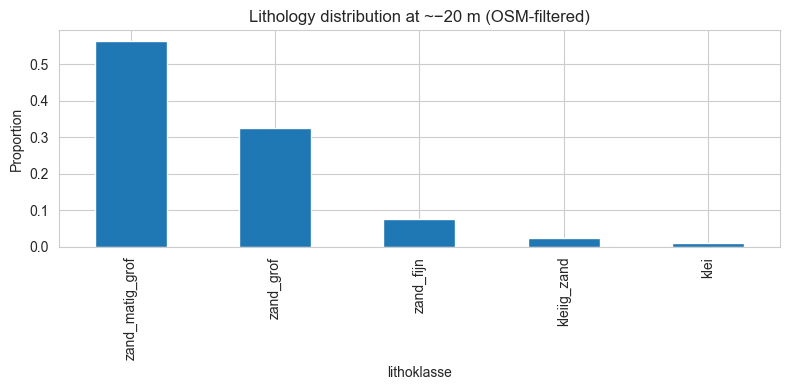

In [34]:
plt.figure(figsize=(8, 4))
litho_counts.plot(kind="bar")
plt.ylabel("Proportion")
plt.title("Lithology distribution at ~−20 m (OSM-filtered)")
plt.tight_layout()
plt.show()


## Step 7 – Train baseline classification models (with OSM-filtered training data)

We use:

- Features: `x`, `y`
- Target: `litho_col`

We split into train/validation sets and try:

- Logistic Regression
- Decision Tree
- Random Forest

Then we pick the model with the best **Macro-F1**.


In [35]:
X = train_filtered[["x", "y"]].values
y = train_filtered[litho_col].values

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RNG_SEED,
    stratify=y,
)

X_train.shape, X_val.shape


((6425, 2), (1607, 2))

## Step 8 – Train baseline models and compare Macro-F1

We try three models:

- Logistic Regression (with `StandardScaler`)
- Decision Tree
- Random Forest

For each model, we:

1. Fit on the training split  
2. Predict on the validation split  
3. Compute **Macro-F1**  
4. Keep track of the best model


In [36]:
models = {
    "logreg": make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=1000, multi_class="auto"),
    ),
    "tree": DecisionTreeClassifier(random_state=RNG_SEED),
    "rf": RandomForestClassifier(
        n_estimators=200,
        random_state=RNG_SEED,
        n_jobs=-1,
    ),
}

results = {}
best_name = None
best_score = -1.0
best_model = None

for name, model in models.items():
    print(f"\nTraining model: {name}")
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_val_pred, average="macro")
    results[name] = f1
    print(f"Macro-F1 ({name}): {f1:.4f}")
    
    if f1 > best_score:
        best_score = f1
        best_name = name
        best_model = model

print("\nValidation Macro-F1 scores:", results)
print(f"Best model: {best_name} with Macro-F1 = {best_score:.4f}")



Training model: logreg
Macro-F1 (logreg): 0.2271

Training model: tree
Macro-F1 (tree): 0.7136

Training model: rf


/Users/natalapuzina/.virtualenvs/s02/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Macro-F1 (rf): 0.7166

Validation Macro-F1 scores: {'logreg': 0.22705759046778465, 'tree': 0.7135979496028957, 'rf': 0.7166289611745044}
Best model: rf with Macro-F1 = 0.7166


In [37]:
# detailed report for the best model
y_val_best = best_model.predict(X_val)
print("\nClassification report for best model:")
print(classification_report(y_val, y_val_best))



Classification report for best model:
                 precision    recall  f1-score   support

           klei       0.61      0.58      0.59        19
    kleiig_zand       0.47      0.37      0.41        38
      zand_fijn       0.78      0.78      0.78       123
      zand_grof       0.88      0.88      0.88       521
zand_matig_grof       0.91      0.92      0.92       906

       accuracy                           0.88      1607
      macro avg       0.73      0.71      0.72      1607
   weighted avg       0.88      0.88      0.88      1607



## Step 8 – Retrain the best model on all filtered voxels

Once we decide which model is best on the validation split, we retrain it
on **all** available training data (`train_data` at the chosen depth window)
to make the most of the data before predicting the test set.


In [38]:
best_model.fit(X, y)
print(f"Best model '{best_name}' retrained on the full training slice.")


Best model 'rf' retrained on the full training slice.


## Step 9 – Predict lithology for the test set

The `test_dataset.csv` file contains 18 locations with:

- `ID`
- `cityName`, `displayName`
- `latitude`, `longitude`
- `class`, `type` (OSM metadata)
- `RD_east`, `RD_north`

We will:

1. Use `RD_east`, `RD_north` as features  
2. Predict lithology using our trained `best_model`  
3. Build a submission dataframe with columns: `ID`, `prediction`


In [39]:
test_df = pd.read_csv(TEST_CSV)
print("Test dataset shape:", test_df.shape)
test_df.head()


Test dataset shape: (18, 9)


,ID,cityName,displayName,latitude,longitude,class,type,RD_east,RD_north
0,0,5283,"152, Groen van Prinstererstraat, Hoogstad, Vla...",51.912476,4.341611,place,house,83037.716304,436409.155066
1,1,5307,"533, Andries van Bronckhorstlaan, Centrum, Spi...",51.844980,4.329021,place,house,82062.232477,428913.878985
2,2,5314,"van Lennepstraat, 's- Gravenzande, 's-Gravenza...",52.001555,4.165362,amenity,parking,71079.916971,446506.937484
3,3,5317,"Van Smaleveltstraat, Schiedam, Zuid-Holland, N...",51.918160,4.387831,man_made,tunnel,86226.007827,436996.718946
4,4,5318,"304, Ganzerikplein, Schiebroek, Hillegersberg-...",51.958796,4.471991,place,house,92071.841460,441440.635968


In [40]:
X_test = test_df[["RD_east", "RD_north"]].values
y_test_pred = best_model.predict(X_test)

submission = pd.DataFrame({
    "ID": test_df["ID"],
    "prediction": y_test_pred,
})

submission.head()


,ID,prediction
0,0,zand_grof
1,1,zand_matig_grof
2,2,klei
3,3,zand_fijn
4,4,zand_grof


## Step 10 – Save your submission as `my_submission.csv`

Finally, we save the predictions as a CSV file with the required format:

```text
ID,prediction
0,zand_grof
1,zand_matig_grof
...


## Compare with `sample_submission.csv`

This step is only to show that our submission has the same structure as the reference.

If `sample_submission.csv` is present, we can compare columns and shapes.


In [41]:
if SAMPLE_SUB_CSV.exists():
    sample_sub = pd.read_csv(SAMPLE_SUB_CSV)
    print("Sample submission shape:", sample_sub.shape)
    display(sample_sub)

    print("\nOur submission shape:", submission.shape)
    display(submission)

    print("\nColumns in sample:", list(sample_sub.columns))
    print("Columns in ours  :", list(submission.columns))
else:
    print("No sample_submission.csv found – skipping comparison.")


Sample submission shape: (18, 2)


,ID,prediction
0,0,klei
1,1,zand_fijn
2,2,klei
3,3,zand_fijn
4,4,klei
5,5,zand_grof
6,6,zand_fijn
7,7,zand_fijn
8,8,klei
9,9,zand_fijn



Our submission shape: (18, 2)


,ID,prediction
0,0,zand_grof
1,1,zand_matig_grof
2,2,klei
3,3,zand_fijn
4,4,zand_grof
5,5,zand_grof
6,6,zand_matig_grof
7,7,zand_fijn
8,8,klei
9,9,zand_fijn



Columns in sample: ['ID', 'prediction']
Columns in ours  : ['ID', 'prediction']
